In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
train_dir=r"C:\Users\AARUSHI TANDON\Downloads\archive\chest_xray\train"


In [2]:
#Load your dataset
train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224,224),
    color_mode='grayscale',
    batch_size=32,
    label_mode='binary',
)

#class names
class_names=train_ds.class_names
print("Classes: ", class_names)

Found 5216 files belonging to 2 classes.
Classes:  ['NORMAL', 'PNEUMONIA']


In [3]:
#check distribution
import numpy as np
class_count={}
for images, labels in train_ds:
    for label in labels.numpy():
        if isinstance(label, np.ndarray):
            label = label.item()  # convert single-value array to scalar
        class_count[label] = class_count.get(label, 0) + 1

print("Class distribution", class_count)

Class distribution {1.0: 3875, 0.0: 1341}


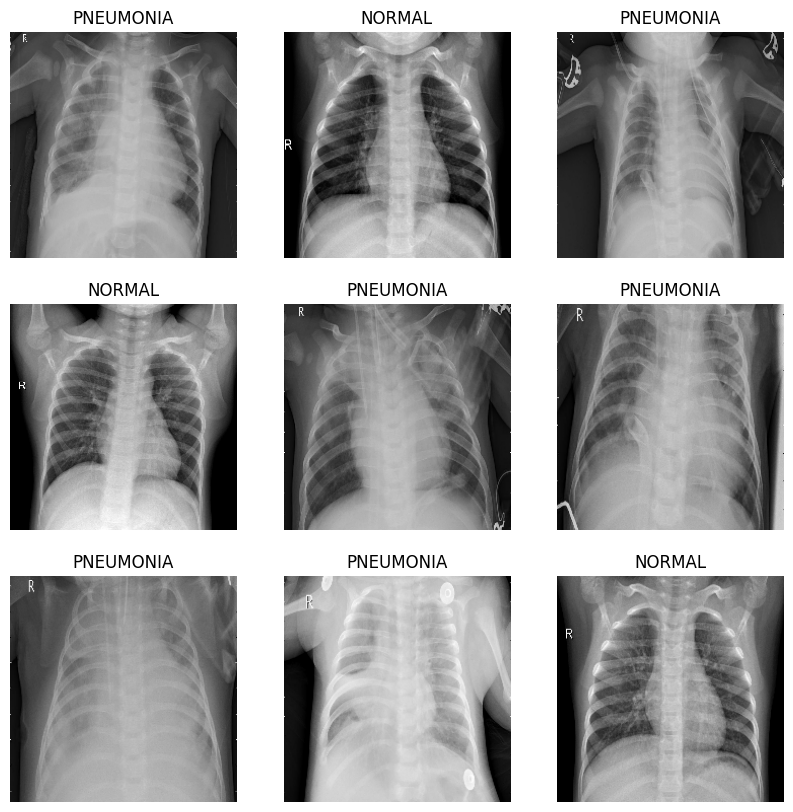

In [4]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.show()


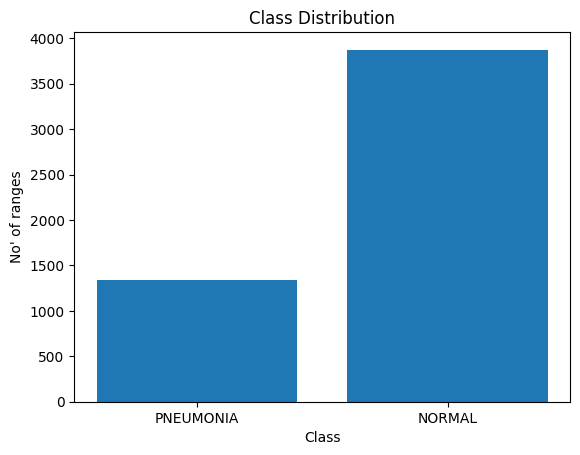

In [5]:
plt.bar(class_count.keys(), class_count.values(), tick_label=class_names)
plt.xlabel("Class")
plt.ylabel("No' of ranges")
plt.title("Class Distribution")
plt.show()


In [6]:
val_dir=r"C:\Users\AARUSHI TANDON\Downloads\archive\chest_xray\val"
val_ds=tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224,224),
    color_mode='grayscale',
    batch_size=32,
    label_mode='binary'
)

Found 16 files belonging to 2 classes.


In [7]:
#NORMALIZE PIXEL VALUES
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


#### Prefetch for performance
- tf.data.AUTOTUNE is a special TensorFlow constan
- it tells tensorflow to decide automatically how many batches to prepare in advance while CPU is training
- it results in faster training
- it helps tenserflow to automatically choose an optimal number of batches to prefetch based on your hardware

In [8]:
AUTOTUNE= tf.data.AUTOTUNE
train_ds=train_ds.prefetch(AUTOTUNE)
val_ds=val_ds.prefetch(AUTOTUNE)

### Residual Block solve the issue of vanishing gradient by introducing skip connections
Y=F(X)+X
WHERE:
- X=input
- F(X) → output of some convolutional layers
- Adding X back → ensures the network can learn an identity mapping easily if needed.

## ARCHITECTURE OF RESIDUAL BLOCK
1. Two 3x3 convulationals
   - both have same number of output channels
   - both are followed by BN and ReLU (except the second conv only BN before addition)
2. Skip connection
   - Add input directly before the final ReLU operation
3. Shape matching (1x1 convulational layer introduction)
   - X and F(X) should have the same shape before addition, so that is why we introduce 1x1 convulational channel to change the number of channels to      transform the input into the desired share for the addition operation

In [9]:
class Residual(tf.keras.Model):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1=tf.keras.layers.Conv2D(num_channels,kernel_size=3, strides=strides, padding='same') #first 3x3 convulational layer
        self.conv2=tf.keras.layers.Conv2D(num_channels, kernel_size=3, strides=1, padding='same') #second 3x3 convulational layer
        # here in the second conv layer strides should always be 1 to keep the size same
        self.conv3=tf.keras.layers.Conv2D(num_channels, kernel_size=1, strides=strides, padding='same') if use_1x1conv else None #1x1 convulational layer for the skip condition
        self.bn1=tf.keras.layers.BatchNormalization() 
        self.bn2=tf.keras.layers.BatchNormalization()

    #forward pass
    def call(self, X, training=False): #training=False → tells BatchNorm whether it’s in training or inference mode.

        #first convulation + BN +ReLU
        Y= tf.keras.activations.relu(self.bn1(self.conv1(X), training=training))

        #second convulation + BN
        Y = self.bn2(self.conv2(Y), training=training) # no relu here because we will apply the skip condtion first

        if self.conv3:
            X=self.conv3(X)

        return tf.keras.activations.relu(Y + X)
        #adds input(X) to output of convs which is the residual connection
        
        

Final summary

Input X

   │
   
   ├─ Conv2D(3x3) → BN → ReLU
   
   │
   
   ├─ Conv2D(3x3) → BN
   
   │
   
Optional 1x1 conv on X if shape differs

   │
   
   └─ Add X + Y
   
       │
       
       └─ ReLU → Output


# RESNET18 ARCHITECTURE FROM SCRATCH
ResNet18 is a Residual Network with 18 layers
Its main idea is:

- Stack residual blocks to make a deep network trainable.

- Use skip connections to avoid vanishing gradients.

- Gradually increase channels and reduce spatial dimensions while preserving information.

## RestNet ARCHITECTURE
1. Input Layer
   - Input image shape (224, 224, 3) for RGB images (different for grayscale images like X-Ray)

2. Initial Convolution + BatchNorm + ReLU + MaxPool
   Layers
   - Conv2D (7x7 kernel, 64 filters, strides=2)
      - Large kernel helps capture low-level features (edges, textures) over a wider area.
      - Stride=2 → reduces spatial dimensions from 224x224 → 112x112.
   - BN
   - ReLU
   - MaxPool(3x3, strides=2)
     - Downsamples features → reduces size to 56x56.
     - Helps network to focus on important region, reduces computation

3. Residual Block Groups
   ResNet18 has 4 groups of residual blocks, each group containing 2 residual blocks:

   - Group 1: 64 channels
     - 2 Residual blocks, each with 2 conv layers(3x3), 64 channels
     - Stride=1 → spatial size stays 56x56.
     - Skip connections = identity (no 1x1 conv needed, because shape doesn’t change).
     - Purpose: learn low-level features while preserving size.
   - Group 2: 128 channels
     - 2 Residual blocks, each with 2 conv layers (3x3), 128 channels.
     - First block uses stride=2 + optional 1x1 conv on skip, downsample 56x56 to 28x28.
     - Second block uses stride=1, keeps size 28x28.
     - Purpose: learn higher-level features, increase representational power.
       - Channels increase → more filters capture more complex patterns.
    - Group 3: 256 channels
      - 2 Residual blocks, 256 channels.
      - First block with strides=2, downsample 28x28 to 14x14
      - Second block with stride=1, size remains same
      - Purpose: capture even more abstract features for classification.
    - Group 4: 512 channels
      - 2 Residual blocks, 512 channels.
      - First block: stride=2, downsample 14x14 to 7x7
      - Second block: stride=1 size 7x7
    
    As spatial dimensions shrink, we increase the number of channels to preserve information capacity.

   - Group 1: 64 channels - captures edges & small textures
   - Group 2: 128 channels - more patterns, larger structures
   - Group 3: 256 channels - even more abstract features
   - Group 4: 512 channels - high-level semantic representation

5. Global Average Pooling
   - converts 7x7x512 to 1x1x512
   - This reduces number of parameters drastically compared to flattening → reduces overfitting.

6. FCNN
   - Uses sigmoid for binary or softmax for multiclass


In [10]:
from tensorflow.keras import layers, Model

def build_resnet18(input_shape=(224,224,1), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    
    # Initial conv + maxpool
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    # Residual blocks
    def res_block(x, num_channels, num_residuals, first_block=False):
        for i in range(num_residuals):
            if i==0 and not first_block:
                x = Residual(num_channels, use_1x1conv=True, strides=2)(x)
            else:
                x = Residual(num_channels)(x)
        return x
    
    x = res_block(x, 64, 2, first_block=True)
    x = res_block(x, 128, 2)
    x = res_block(x, 256, 2)
    x = res_block(x, 512, 2)
    
    # Classifier
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # binary classification
    
    return Model(inputs, outputs)

model = build_resnet18()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 112, 112, 64)        │           3,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual (Residual)                  │ (None, 56, 56, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_1 (Residual)                │ (None, 56, 56, 64)          │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_2 (Residual)                │ (None, 28, 28, 128)         │         230,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_3 (Residual)                │ (None, 28, 28, 128)         │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_4 (Residual)                │ (None, 14, 14, 256)         │         920,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_5 (Residual)                │ (None, 14, 14, 256)         │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_6 (Residual)                │ (None, 7, 7, 512)           │       3,675,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_7 (Residual)                │ (None, 7, 7, 512)           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,181,569 (42.65 MB)

 Trainable params: 11,173,761 (42.62 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [11]:
#complie and train
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 970s 6s/step - accuracy: 0.8421 - loss: 0.5221 - val_accuracy: 0.5000 - val_loss: 9.6906
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 926s 6s/step - accuracy: 0.9487 - loss: 0.1352 - val_accuracy: 0.5000 - val_loss: 10.1579
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 912s 6s/step - accuracy: 0.9679 - loss: 0.0843 - val_accuracy: 0.5000 - val_loss: 5.9009
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 921s 6s/step - accuracy: 0.9675 - loss: 0.0822 - val_accuracy: 0.5000 - val_loss: 3.1226
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 872s 5s/step - accuracy: 0.9740 - loss: 0.0725 - val_accuracy: 0.5000 - val_loss: 3.8476
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 858s 5s/step - accuracy: 0.9742 - loss: 0.0696 - val_accuracy: 0.6875 - val_loss: 1.4027
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 874s 5s/step - accuracy: 0.9761 - loss: 0.0623 - val_accuracy: 0.5000 - val_loss: 56.0557
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 860s 5s/step - accuracy: 0.9845 - loss: 0.0455 - val_ac

In [12]:
test_dir=r"C:\Users\AARUSHI TANDON\Downloads\archive\chest_xray\test"
test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224,224),
    color_mode='grayscale',
    batch_size=32,
    label_mode='binary',
)


Found 624 files belonging to 2 classes.
